In [1]:
import numpy as np
import matplotlib.pyplot as plt
from uncertainties import ufloat

In [2]:
#exact solutions
def analytical_F(T,ntoys):
    #kb = 1 and J = 1
    K = 2*np.sinh(2/T)/(np.cosh(2/T))**2
    
    term_1 = np.log(2*np.cosh(2/T))
    
    b = np.pi/2
    a = 0
    
    X = np.random.uniform(a,b,ntoys)
    
    def f(x):
        return np.log(1/2 * (1 + (1 - K**2 * np.sin(x)**2)**0.5))/np.pi
    
    integral = (b-a)/ntoys * np.sum(f(X))
    
    #std(integral) = std(func(xrandoms))/sqrt(N)
    err_integral = np.std(f(X))/np.sqrt(ntoys)
    
    int_u = ufloat(integral, err_integral)
    
    ln_lam = term_1 + int_u
    
    return -T*ln_lam

In [3]:
#get energy function for 2D ising
def Energy(latt): #fast energy calc w no for loops thanks to chat gtp
    Ene = -np.sum(latt*(np.roll(latt,1,axis=0) + np.roll(latt,-1,axis=0) + np.roll(latt,1,axis=1) + np.roll(latt,-1,axis=1)))
    return int(Ene/2.)

#figure out energy spectrum
def calc_E_spectrum(n):
    n_squared = n**2
    #create flat lattice and square lattice for minimum energy
    min_lat_flat = np.array([1]*n_squared)
    min_lat = min_lat_flat.reshape((n,n))
    Emin = float(Energy(min_lat))
    
    #Max energy is every other spin is flipped
    min_lat_flat[::2] = -1
    max_lat = min_lat_flat.reshape((n,n))
    if n%2 == 0:
        max_lat[::2] = max_lat[::2]*-1
    Emax = float(Energy(max_lat))

    #flip a spin to see how it is discritized
    flip_lat = np.array([-1] + [1]*(n_squared - 1)).reshape((n,n))
    Eflip = Energy(flip_lat)
    
    #calculate the change in energy
    dE = (Eflip-Emin)/2
    
    #generate the spectrum
    print(f'Emax = {Emax}, Emin = {Emin}, dE = {dE}')
    E_spectrum = np.arange(Emin,Emax+dE,dE)
    return np.delete(E_spectrum, [1,-2]) #second and second to last energies are not reachable so they are removed


def Wang_Landau(N):
    N_squared = N**2
    lattice = (2*np.random.randint(2,size=(1,N_squared))[0]-1).reshape((N,N))

    E_spectrum = calc_E_spectrum(N)
    E_curr = Energy(lattice)

    #density of states has form of energy spectrum!
    log_g = np.zeros_like(E_spectrum) #would be all 0, starting g at 1

    #initialize histogram -> what will be judged if flat
    histogram = np.zeros_like(E_spectrum)

    #modification factor
    f = 1 #ln(e) = 1
    tot = 0
    while f>10**-8:
        #chooose random energy
        prop_bits = (np.random.randint(0,N), np.random.randint(0,N))
        lattice[prop_bits] = lattice[prop_bits]*-1
        E_proposed = Energy(lattice)

        #where is the energy value for the current and proposed
        ind_E_curr = np.where(E_spectrum==E_curr)[0][0]
        ind_E_proposed = np.where(E_spectrum==E_proposed)[0][0]

        #calculate the density of states
        g_curr = log_g[ind_E_curr]
        g_proposed = log_g[ind_E_proposed]

        #calc prob of acceptance
        prob_acceptance = np.exp(g_curr - g_proposed) #g_curr/g_proposed
        r = np.random.uniform(0,1)
        if r < np.minimum(1,prob_acceptance):
            E_curr = E_proposed
            ind_E_curr = ind_E_proposed

        else:
            #reject reflip spin
            lattice[prop_bits] = lattice[prop_bits]*-1

        histogram[ind_E_curr] += 1
        log_g[ind_E_curr] += f #add f because working w natural log, log(g*f) = log(g)+log(f)
        tot+=1
        if np.min(histogram) >= np.mean(histogram)*0.8:
            print('success', tot)
            #plt.bar(E_spectrum,histogram,width=4)
            histogram = np.zeros_like(E_spectrum)
            f *= 0.5
    
    return log_g

def Fast_WL(N):
    N_squared = N**2
    lattice = (2*np.random.randint(2,size=(1,N_squared))[0]-1).reshape((N,N))

    E_spectrum = calc_E_spectrum(N)
    #E_spectrum = E_spectrum[E_spectrum >= 0] #take only half the spectrum its symmetric!

    #following line is to test overlap!
    E_spectrum = E_spectrum[E_spectrum >= 0.1*E_spectrum[0]] #take only half the spectrum its symmetric!

    print(E_spectrum[0])
    
    E_curr = Energy(lattice)
    while E_curr <= 0:
        lattice = (2*np.random.randint(2,size=(1,N_squared))[0]-1).reshape((N,N))
        E_curr = Energy(lattice)

    #density of states has form of energy spectrum!
    log_g = np.zeros_like(E_spectrum) #would be all 0, starting g at 1

    #initialize histogram -> what will be judged if flat
    histogram = np.zeros_like(E_spectrum)

    #modification factor
    f = 1 #ln(e) = 1
    tot = 0
    c=0
    while f>10**-8:
        #chooose random energy
        prop_bits = (np.random.randint(0,N), np.random.randint(0,N))
        site = lattice[prop_bits] # its spin
        i, j = prop_bits
        nearest_neighbors = lattice[(i+1)%N, j] + lattice[i,(j+1)%N] + lattice[(i-1)%N,j] + lattice[i,(j-1)%N]
        E_proposed = E_curr + 2*site*nearest_neighbors       # The energy of the tryed step
            
        #where is the energy value for the current and proposed
        ind_E_curr = np.where(E_spectrum==E_curr)[0][0]
        ind_E_proposed = np.where(E_spectrum==E_proposed)[0][0]

        if E_proposed < E_spectrum[0]:
            #reject the proposed spin flip here
            histogram[ind_E_curr] += 1
            log_g[ind_E_curr] += f 
            E_proposed = E_curr
            if np.min(histogram) >= np.mean(histogram)*0.8:
                c+=1
                print(c,'success', tot)
                #plt.bar(E_spectrum,histogram,width=4)
                histogram = np.zeros_like(E_spectrum)
                f *= 0.5
            continue
        
        #calculate the density of states
        g_curr = log_g[ind_E_curr]
        g_proposed = log_g[ind_E_proposed]

        #calc prob of acceptance
        prob_acceptance = np.exp(g_curr - g_proposed) #g_curr/g_proposed
        r = np.random.uniform(0,1)
        if r < np.minimum(1,prob_acceptance):
            E_curr = E_proposed
            ind_E_curr = ind_E_proposed
            lattice[prop_bits] = lattice[prop_bits]*-1
            
        histogram[ind_E_curr] += 1
        log_g[ind_E_curr] += f #add f because working w natural log, log(g*f) = log(g)+log(f)
        tot+=1
        if np.min(histogram) >= np.mean(histogram)*0.8:
            c+=1
            print(c,'success', tot)
            #plt.bar(E_spectrum,histogram,width=4)
            histogram = np.zeros_like(E_spectrum)
            f *= 0.5
            
    print(f'Done with {N}')
    log_g = log_g[abs(int(E_spectrum[0]/4)):] #burn off the overlap
    return np.concatenate((log_g[1:][::-1],log_g), axis=0)

Emax = 200.0, Emin = -200.0, dE = 4.0
[-20. -16. -12.  -8.  -4.   0.   4.   8.  12.  16.  20.  24.  28.  32.
  36.  40.  44.  48.  52.  56.  60.  64.  68.  72.  76.  80.  84.  88.
  92.  96. 100. 104. 108. 112. 116. 120. 124. 128. 132. 136. 140. 144.
 148. 152. 156. 160. 164. 168. 172. 176. 180. 184. 188. 192. 200.]
1 success 85872
2 success 105484
3 success 120124
4 success 157132
5 success 217119
6 success 263466
7 success 300994
8 success 404501
9 success 463973
10 success 591383
11 success 720767
12 success 899310
13 success 1059228
14 success 1571743
15 success 1948815
16 success 3460115
17 success 4738658
18 success 5183039
19 success 5336933
20 success 5620720
21 success 5843360
22 success 6044981
23 success 6965096
24 success 7529127
25 success 7860030
26 success 8491270
27 success 8946389
Done with 10
Emax = 200.0, Emin = -200.0, dE = 4.0


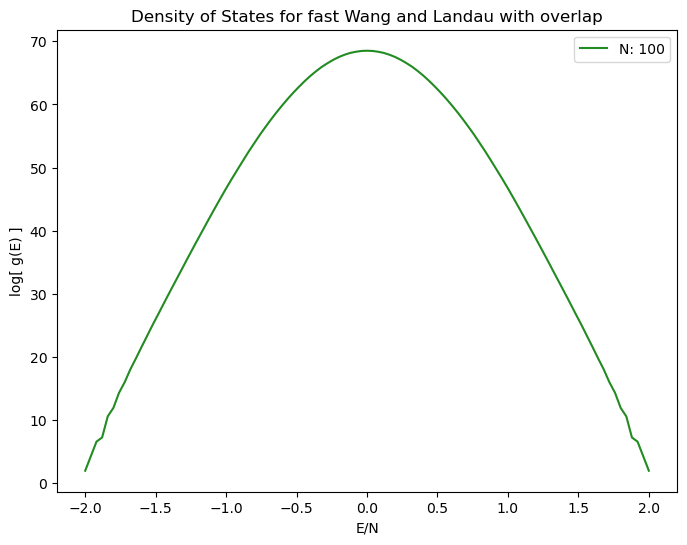

In [98]:
g_test = Fast_WL(10)
g_test_n = g_test - g_test[0] + 2
E_test = calc_E_spectrum(10)
plt.figure(figsize=(8,6))
plt.title('Density of States for fast Wang and Landau with overlap')
plt.plot(E_test/10**2,g_test_n,color='forestgreen',label=f'N: {10**2}')
plt.xlabel('E/N')
plt.ylabel('log[ g(E) ]')
plt.legend()

In [10]:
#Get density of states for differnet sizes
lat_sizes = [4,8]
#lat_sizes = [10]
#log_g_s = [Fast_WL(i) for i in lat_sizes] + [Wang_Landau(i) for i in lat_sizes] 
log_g_s = [Fast_WL(i) for i in lat_sizes]

Emax = 32.0, Emin = -32.0, dE = 4.0
[ 0.  4.  8. 12. 16. 20. 24. 32.]
1 success 634
2 success 1212
3 success 1780
4 success 2406
5 success 3708
6 success 4718
7 success 5658
8 success 6697
9 success 8083
10 success 9252
11 success 12254
12 success 24894
13 success 25711
14 success 26384
15 success 34779
16 success 49514
17 success 49704
18 success 55951
19 success 78828
20 success 83294
21 success 84378
22 success 98241
23 success 98939
24 success 181008
25 success 181975
26 success 192022
27 success 194460
Done with 4
Emax = 128.0, Emin = -128.0, dE = 4.0
[-12.  -8.  -4.   0.   4.   8.  12.  16.  20.  24.  28.  32.  36.  40.
  44.  48.  52.  56.  60.  64.  68.  72.  76.  80.  84.  88.  92.  96.
 100. 104. 108. 112. 116. 120. 128.]
1 success 21808
2 success 36669
3 success 57259
4 success 77318
5 success 105441
6 success 127571
7 success 154361
8 success 170019
9 success 199428
10 success 301204
11 success 375750
12 success 442473
13 success 511558
14 success 668337
15 success 1015854


Emax = 32.0, Emin = -32.0, dE = 4.0
Emax = 128.0, Emin = -128.0, dE = 4.0
Emax = 512.0, Emin = -512.0, dE = 4.0


IndexError: list index out of range

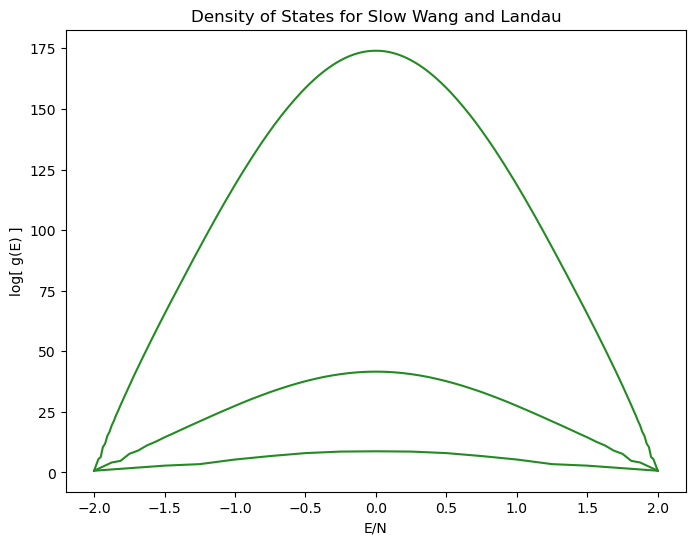

In [11]:
#plot density of states
#norm_log_g_s = [np.log(np.exp(g-g[0])+2) for g in log_g_s]                
lat_sizes = [4,8,16]
               
E_spec_s = [np.array(calc_E_spectrum(i)) for i in lat_sizes]

plt.figure(figsize=(8,6))
for i in range(len(norm_log_g_s)):
    plt.title('Density of States for Slow Wang and Landau')
    plt.plot(E_spec_s[i]/lat_sizes[i]**2,norm_log_g_s[i],label=f'N: {lat_sizes[i]**2}',color='forestgreen')
    plt.xlabel('E/N')
    plt.ylabel('log[ g(E) ]')

    
plt.legend()

In [4]:
#hold the density of states for 4,8,16 with 80% flatness

list_log_g = [[2.0, 4.723603382706642, 5.382401242852211, 7.310123264789581, 8.74639318883419, 9.965435355901718, 10.591730803251266, 10.708393439650536, 10.591730803251266, 9.965435355901718, 8.74639318883419, 7.310123264789581, 5.382401242852211, 4.723603382706642, 2.0], [2.0, 6.072685167193413, 6.7534599751234055, 9.660842016339302, 11.007485538721085, 13.131963893771172, 14.684164628386497, 16.473111927509308, 18.10770544409752, 19.80092178285122, 21.463676258921623, 23.079152032732964, 24.717748746275902, 26.338737681508064, 27.907784163951874, 29.46429942548275, 30.992101058363914, 32.43389146029949, 33.812933176755905, 35.15250642597675, 36.38552802801132, 37.563073337078094, 38.64120405912399, 39.63431170582771, 40.52323704957962, 41.3258006721735, 41.99956601858139, 42.55881331861019, 43.006954461336136, 43.3340036123991, 43.52132701873779, 43.58081932365894, 43.52132701873779, 43.3340036123991, 43.006954461336136, 42.55881331861019, 41.99956601858139, 41.3258006721735, 40.52323704957962, 39.63431170582771, 38.64120405912399, 37.563073337078094, 36.38552802801132, 35.15250642597675, 33.812933176755905, 32.43389146029949, 30.992101058363914, 29.46429942548275, 27.907784163951874, 26.338737681508064, 24.717748746275902, 23.079152032732964, 21.463676258921623, 19.80092178285122, 18.10770544409752, 16.473111927509308, 14.684164628386497, 13.131963893771172, 11.007485538721085, 9.660842016339302, 6.7534599751234055, 6.072685167193413, 2.0], [2.0, 7.566821172833443, 8.297474086284637, 12.45699854195118, 13.837479650974274, 17.01308573782444, 18.73959471285343, 21.36909580230713, 23.284768849611282, 25.61312209069729, 27.584563449025154, 29.745712488889694, 31.74463102221489, 33.80775821208954, 35.78971326351166, 37.79017896950245, 39.74068604409695, 41.69528405368328, 43.60952466726303, 45.502021819353104, 47.38099452853203, 49.25689807534218, 51.12124575674534, 52.97495120763779, 54.81934078037739, 56.6297350525856, 58.45017096400261, 60.24997319281101, 62.06775462627411, 63.840321123600006, 65.61692073941231, 67.37720091640949, 69.13965514302254, 70.90403673052788, 72.64065001904964, 74.36965350806713, 76.11239509284496, 77.83941316604614, 79.57986222207546, 81.2948185801506, 83.02047146856785, 84.73493753373623, 86.43693283200264, 88.14086619019508, 89.84020002186298, 91.53295174241066, 93.22123789787292, 94.90126143395901, 96.59247030317783, 98.26474399864674, 99.91921924054623, 101.58029276132584, 103.22988669574261, 104.86648742854595, 106.5010777413845, 108.12429015338421, 109.73183220624924, 111.3272213190794, 112.91436325013638, 114.4831980317831, 116.05048255622387, 117.61009369790554, 119.15449550747871, 120.68086428940296, 122.19710810482502, 123.69063672423363, 125.17977152764797, 126.63677233457565, 128.09895507991314, 129.55713602900505, 130.97365446388721, 132.39551489055157, 133.7892321497202, 135.17840014398098, 136.5441078990698, 137.89323070645332, 139.21423402428627, 140.51640997827053, 141.81377302110195, 143.09108075499535, 144.34693558514118, 145.58874827623367, 146.80582939088345, 148.0081829726696, 149.17487961053848, 150.32418698072433, 151.44932939112186, 152.55451627075672, 153.6410800665617, 154.70630677044392, 155.75386933982372, 156.77864031493664, 157.7877404242754, 158.78243844211102, 159.73964242637157, 160.66441386938095, 161.57564298808575, 162.4614149928093, 163.325240701437, 164.15351459383965, 164.9641549885273, 165.7475847452879, 166.50990195572376, 167.23310866951942, 167.93869845569134, 168.6139100342989, 169.26540911197662, 169.88213668763638, 170.47057688236237, 171.03205381333828, 171.57155740261078, 172.0717674344778, 172.55030681192875, 172.99656516313553, 173.4133045375347, 173.79956459999084, 174.15433490276337, 174.48318074643612, 174.77553042769432, 175.04078064858913, 175.2780483365059, 175.47757536172867, 175.64564895629883, 175.78539761900902, 175.88733081519604, 175.96450355648994, 176.01064078509808, 176.02265614271164, 176.01064078509808, 175.96450355648994, 175.88733081519604, 175.78539761900902, 175.64564895629883, 175.47757536172867, 175.2780483365059, 175.04078064858913, 174.77553042769432, 174.48318074643612, 174.15433490276337, 173.79956459999084, 173.4133045375347, 172.99656516313553, 172.55030681192875, 172.0717674344778, 171.57155740261078, 171.03205381333828, 170.47057688236237, 169.88213668763638, 169.26540911197662, 168.6139100342989, 167.93869845569134, 167.23310866951942, 166.50990195572376, 165.7475847452879, 164.9641549885273, 164.15351459383965, 163.325240701437, 162.4614149928093, 161.57564298808575, 160.66441386938095, 159.73964242637157, 158.78243844211102, 157.7877404242754, 156.77864031493664, 155.75386933982372, 154.70630677044392, 153.6410800665617, 152.55451627075672, 151.44932939112186, 150.32418698072433, 149.17487961053848, 148.0081829726696, 146.80582939088345, 145.58874827623367, 144.34693558514118, 143.09108075499535, 141.81377302110195, 140.51640997827053, 139.21423402428627, 137.89323070645332, 136.5441078990698, 135.17840014398098, 133.7892321497202, 132.39551489055157, 130.97365446388721, 129.55713602900505, 128.09895507991314, 126.63677233457565, 125.17977152764797, 123.69063672423363, 122.19710810482502, 120.68086428940296, 119.15449550747871, 117.61009369790554, 116.05048255622387, 114.4831980317831, 112.91436325013638, 111.3272213190794, 109.73183220624924, 108.12429015338421, 106.5010777413845, 104.86648742854595, 103.22988669574261, 101.58029276132584, 99.91921924054623, 98.26474399864674, 96.59247030317783, 94.90126143395901, 93.22123789787292, 91.53295174241066, 89.84020002186298, 88.14086619019508, 86.43693283200264, 84.73493753373623, 83.02047146856785, 81.2948185801506, 79.57986222207546, 77.83941316604614, 76.11239509284496, 74.36965350806713, 72.64065001904964, 70.90403673052788, 69.13965514302254, 67.37720091640949, 65.61692073941231, 63.840321123600006, 62.06775462627411, 60.24997319281101, 58.45017096400261, 56.6297350525856, 54.81934078037739, 52.97495120763779, 51.12124575674534, 49.25689807534218, 47.38099452853203, 45.502021819353104, 43.60952466726303, 41.69528405368328, 39.74068604409695, 37.79017896950245, 35.78971326351166, 33.80775821208954, 31.74463102221489, 29.745712488889694, 27.584563449025154, 25.61312209069729, 23.284768849611282, 21.36909580230713, 18.73959471285343, 17.01308573782444, 13.837479650974274, 12.45699854195118, 8.297474086284637, 7.566821172833443, 2.0]]

log_32 = np.array([40681.96132624149, 40688.837775975466, 40689.55966296792, 40695.124081522226, 40696.513676419854, 40700.959612607956, 40702.75746071339, 40706.57554522157, 40708.59358024597, 40711.99353572726, 40714.182159096, 40717.25452621281, 40719.56205767393, 40722.408229231834, 40724.779523298144, 40727.466881752014, 40729.85359430313, 40732.443684101105, 40734.83413092792, 40737.346484050155, 40739.74046750367, 40742.165239050984, 40744.546982467175, 40746.93628746271, 40749.27131190896, 40751.61774626374, 40753.937870025635, 40756.240134984255, 40758.55230142176, 40760.84054411948, 40763.09549476206, 40765.358478948474, 40767.59612338245, 40769.83564354479, 40772.04967702925, 40774.26541592181, 40776.46896997094, 40778.647890642285, 40780.83939088881, 40783.00156740844, 40785.15068973601, 40787.30660825968, 40789.45770600438, 40791.58996531367, 40793.70912396908, 40795.821025669575, 40797.9402256161, 40800.04186435044, 40802.13115528226, 40804.20571707189, 40806.300462022424, 40808.365854501724, 40810.443264991045, 40812.49398931861, 40814.540072247386, 40816.58700209856, 40818.62243929505, 40820.664406389, 40822.68696844578, 40824.706022784114, 40826.728779643774, 40828.733657091856, 40830.74121209979, 40832.744933217764, 40834.73698921502, 40836.722781449556, 40838.70334228873, 40840.68474781513, 40842.63804131746, 40844.613653719425, 40846.57115164399, 40848.53615395725, 40850.48554480076, 40852.4352992028, 40854.37206694484, 40856.317322686315, 40858.262453600764, 40860.18437971175, 40862.11767324805, 40864.04925169051, 40865.97005574405, 40867.891602009535, 40869.804390728474, 40871.71027649939, 40873.62338037789, 40875.52356636524, 40877.41657194495, 40879.307015776634, 40881.19230982661, 40883.08273218572, 40884.978413656354, 40886.84711763263, 40888.72952608764, 40890.60854224861, 40892.485740467906, 40894.34698103368, 40896.209268301725, 40898.0708745271, 40899.93754938245, 40901.79546120763, 40903.65762498975, 40905.51242671907, 40907.35622505844, 40909.20423513651, 40911.03840191662, 40912.86952087283, 40914.70413714647, 40916.54032835364, 40918.36429132521, 40920.198007911444, 40922.02433793247, 40923.8379791975, 40925.65516847372, 40927.47522260249, 40929.29376387596, 40931.10019381344, 40932.91439644992, 40934.721362516284, 40936.5266944021, 40938.33037686348, 40940.13223980367, 40941.93596372008, 40943.721402511, 40945.515032470226, 40947.301889523864, 40949.096562922, 40950.883287250996, 40952.66611422598, 40954.453145504, 40956.2302556932, 40958.00647433102, 40959.790216743946, 40961.549097687006, 40963.331327438354, 40965.102192640305, 40966.87199924886, 40968.64425699413, 40970.41348819435, 40972.17492003739, 40973.937876567245, 40975.703620910645, 40977.45807825029, 40979.22574466467, 40980.98206117749, 40982.740598231554, 40984.49411278963, 40986.2388125658, 40987.9932602793, 40989.75061503053, 40991.49812684953, 40993.23742824793, 40994.97718721628, 40996.724466234446, 40998.47127786279, 41000.214409425855, 41001.965821027756, 41003.71054439247, 41005.44562241435, 41007.18129679561, 41008.91511453688, 41010.64752610028, 41012.38726083934, 41014.11738790572, 41015.85159641504, 41017.58149680495, 41019.30860808492, 41021.03506116569, 41022.7582924813, 41024.47700421512, 41026.19839847088, 41027.92486937344, 41029.649341106415, 41031.359878599644, 41033.0839060545, 41034.800685718656, 41036.51991145313, 41038.231354773045, 41039.95077940822, 41041.659061312675, 41043.37390562892, 41045.09026752412, 41046.79504801333, 41048.50454162061, 41050.208070099354, 41051.91523779929, 41053.62042681873, 41055.32148937881, 41057.019748181105, 41058.716445207596, 41060.41077302396, 41062.1033911407, 41063.80088408291, 41065.49544470012, 41067.18242329359, 41068.87600442767, 41070.56599800289, 41072.25460782647, 41073.94415934384, 41075.620118930936, 41077.29628914595, 41078.96955795586, 41080.64816188812, 41082.32269066572, 41083.99580782652, 41085.667477443814, 41087.33135461807, 41088.99073776603, 41090.657083272934, 41092.30622506142, 41093.95737195015, 41095.60613761842, 41097.26102910936, 41098.906710892916, 41100.55578491092, 41102.20476146042, 41103.839698553085, 41105.480206504464, 41107.11826425791, 41108.753901198506, 41110.38204544783, 41112.01289395988, 41113.6361041069, 41115.25884862244, 41116.87801408768, 41118.492991790175, 41120.11382228136, 41121.716170072556, 41123.32127766311, 41124.92984388769, 41126.53451393545, 41128.129889175296, 41129.72422622144, 41131.316307365894, 41132.9040773958, 41134.492143169045, 41136.07897987962, 41137.6578745991, 41139.23885239661, 41140.81216271222, 41142.38427476585, 41143.946057111025, 41145.5119728297, 41147.07675431669, 41148.63362573087, 41150.189850986004, 41151.744148522615, 41153.2920871526, 41154.83712762594, 41156.384696662426, 41157.92380109429, 41159.45576673746, 41160.992183089256, 41162.524052754045, 41164.05076445639, 41165.57642251253, 41167.10010869801, 41168.61383087933, 41170.12439592183, 41171.634392261505, 41173.136242344975, 41174.64050975442, 41176.13686977327, 41177.63353712857, 41179.1221666038, 41180.61095991731, 41182.08751952648, 41183.57413546741, 41185.05104134977, 41186.527146205306, 41187.99640648067, 41189.47095938027, 41190.930466890335, 41192.38826751709, 41193.84505015612, 41195.29564316571, 41196.74146093428, 41198.18173959851, 41199.621740564704, 41201.058758080006, 41202.49322298169, 41203.920935586095, 41205.339800059795, 41206.76039206982, 41208.18608224392, 41209.595616430044, 41210.99794687331, 41212.398230329156, 41213.7964284569, 41215.19949121773, 41216.58399729431, 41217.97349791229, 41219.3591697067, 41220.737745031714, 41222.11246743798, 41223.48509411514, 41224.848911345005, 41226.217025876045, 41227.57425804436, 41228.923686400056, 41230.27352552116, 41231.61831331253, 41232.950354233384, 41234.28787216544, 41235.61967031658, 41236.950511053205, 41238.27372764051, 41239.5936499387, 41240.908217161894, 41242.221936285496, 41243.52537192404, 41244.82411518693, 41246.12303119898, 41247.41763716936, 41248.70256482065, 41249.98594853282, 41251.26660616696, 41252.53749619424, 41253.81333360076, 41255.08177152276, 41256.340977311134, 41257.60200151801, 41258.8518820554, 41260.09633669257, 41261.33558702469, 41262.57376804948, 41263.8063030839, 41265.03743699193, 41266.26115655899, 41267.46993653476, 41268.68274694681, 41269.8866943866, 41271.08986182511, 41272.28645993769, 41273.476757347584, 41274.66392274201, 41275.84723253548, 41277.02954606712, 41278.196271032095, 41279.36532831192, 41280.5282741189, 41281.68415336311, 41282.84052050114, 41283.99008564651, 41285.130501419306, 41286.269392475486, 41287.399850428104, 41288.52584245801, 41289.647546738386, 41290.7651347816, 41291.87055668235, 41292.974757924676, 41294.07979050279, 41295.17667257786, 41296.26831565797, 41297.35441851616, 41298.43031089008, 41299.50293067098, 41300.56846310198, 41301.62541015446, 41302.68248666823, 41303.732025280595, 41304.776300251484, 41305.815335989, 41306.85003460944, 41307.87639051676, 41308.900871858, 41309.91862615943, 41310.93227405846, 41311.94133774936, 41312.94137829542, 41313.94328428805, 41314.93965172768, 41315.922781556845, 41316.90321394801, 41317.87313708663, 41318.83828420937, 41319.79928523302, 41320.74757172167, 41321.69037158787, 41322.63436408341, 41323.56862141192, 41324.50131455064, 41325.422166243196, 41326.33801230788, 41327.250455483794, 41328.1571918875, 41329.058205887675, 41329.95418226719, 41330.84429883957, 41331.73178859055, 41332.60640330613, 41333.479720681906, 41334.34376856685, 41335.20105077326, 41336.05249643326, 41336.90004955232, 41337.74420250952, 41338.57372057438, 41339.396991208196, 41340.212159231305, 41341.02618870139, 41341.83316113055, 41342.63390289247, 41343.427080869675, 41344.211826592684, 41344.99093790352, 41345.76412843168, 41346.53623688221, 41347.29970546067, 41348.0541100651, 41348.79816919565, 41349.54345579445, 41350.27959612012, 41351.011172652245, 41351.7357519865, 41352.451773419976, 41353.16364067793, 41353.86278146505, 41354.55927978456, 41355.24928466976, 41355.93238440156, 41356.60773327947, 41357.27664709091, 41357.93848118186, 41358.5910268873, 41359.234788522124, 41359.87545454502, 41360.50795729458, 41361.133615761995, 41361.75290994346, 41362.366829916835, 41362.97724285722, 41363.57667686045, 41364.171181976795, 41364.7580807209, 41365.33739736676, 41365.91381637752, 41366.47471252084, 41367.03189021349, 41367.583008766174, 41368.12775629759, 41368.661290988326, 41369.189004033804, 41369.71115259826, 41370.22605650127, 41370.73251309991, 41371.23419125378, 41371.72626622021, 41372.21170859039, 41372.69117102027, 41373.16133622825, 41373.61926995218, 41374.07299606502, 41374.5199021399, 41374.96334679425, 41375.396680787206, 41375.82167044282, 41376.24201260507, 41376.65166324377, 41377.058605998755, 41377.45404726267, 41377.84075766802, 41378.221763029695, 41378.597202003, 41378.96545061469, 41379.32427789271, 41379.678288668394, 41380.02260103822, 41380.359831124544, 41380.685853242874, 41381.01049682498, 41381.32710775733, 41381.633838549256, 41381.93111295998, 41382.222812488675, 41382.506344497204, 41382.781792506576, 41383.04907491803, 41383.306418284774, 41383.56105069816, 41383.80815306306, 41384.04495768249, 41384.27445471287, 
          41384.497040465474, 41384.71350879967, 41384.92073653638, 41385.12059289217, 41385.31275399029, 41385.497463196516, 41385.67236550152, 41385.84002226591, 41385.99751833081, 41386.1514274925, 41386.296271815896, 41386.43110150099, 41386.560442358255, 41386.67816951871, 41386.78986231983, 41386.89505819976, 41386.98824585974, 41387.07670344412, 41387.1592656821, 41387.232499957085, 41387.297981485724, 41387.35643795133, 41387.40490928292, 41387.447978913784, 41387.48353469372, 41387.51026122272, 41387.52908436954, 41387.54029303789, 41387.545640036464, 41387.54029303789, 41387.52908436954, 41387.51026122272, 41387.48353469372, 41387.447978913784, 41387.40490928292, 41387.35643795133, 41387.297981485724, 41387.232499957085, 41387.1592656821, 41387.07670344412, 41386.98824585974, 41386.89505819976, 41386.78986231983, 41386.67816951871, 41386.560442358255, 41386.43110150099, 41386.296271815896, 41386.1514274925, 41385.99751833081, 41385.84002226591, 41385.67236550152, 41385.497463196516, 41385.31275399029, 41385.12059289217, 41384.92073653638, 41384.71350879967, 41384.497040465474, 41384.27445471287, 41384.04495768249, 41383.80815306306, 41383.56105069816, 41383.306418284774, 41383.04907491803, 41382.781792506576, 41382.506344497204, 41382.222812488675, 41381.93111295998, 41381.633838549256, 41381.32710775733, 41381.01049682498, 41380.685853242874, 41380.359831124544, 41380.02260103822, 41379.678288668394, 41379.32427789271, 41378.96545061469, 41378.597202003, 41378.221763029695, 41377.84075766802, 41377.45404726267, 41377.058605998755, 41376.65166324377, 41376.24201260507, 41375.82167044282, 41375.396680787206, 41374.96334679425, 41374.5199021399, 41374.07299606502, 41373.61926995218, 41373.16133622825, 41372.69117102027, 41372.21170859039, 41371.72626622021, 41371.23419125378, 41370.73251309991, 41370.22605650127, 41369.71115259826, 41369.189004033804, 41368.661290988326, 41368.12775629759, 41367.583008766174, 41367.03189021349, 41366.47471252084, 41365.91381637752, 41365.33739736676, 41364.7580807209, 41364.171181976795, 41363.57667686045, 41362.97724285722, 41362.366829916835, 41361.75290994346, 41361.133615761995, 41360.50795729458, 41359.87545454502, 41359.234788522124, 41358.5910268873, 41357.93848118186, 41357.27664709091, 41356.60773327947, 41355.93238440156, 41355.24928466976, 41354.55927978456, 41353.86278146505, 41353.16364067793, 41352.451773419976, 41351.7357519865, 41351.011172652245, 41350.27959612012, 41349.54345579445, 41348.79816919565, 41348.0541100651, 41347.29970546067, 41346.53623688221, 41345.76412843168, 41344.99093790352, 41344.211826592684, 41343.427080869675, 41342.63390289247, 41341.83316113055, 41341.02618870139, 41340.212159231305, 41339.396991208196, 41338.57372057438, 41337.74420250952, 41336.90004955232, 41336.05249643326, 41335.20105077326, 41334.34376856685, 41333.479720681906, 41332.60640330613, 41331.73178859055, 41330.84429883957, 41329.95418226719, 41329.058205887675, 41328.1571918875, 41327.250455483794, 41326.33801230788, 41325.422166243196, 41324.50131455064, 41323.56862141192, 41322.63436408341, 41321.69037158787, 41320.74757172167, 41319.79928523302, 41318.83828420937, 41317.87313708663, 41316.90321394801, 41315.922781556845, 41314.93965172768, 41313.94328428805, 41312.94137829542, 41311.94133774936, 41310.93227405846, 41309.91862615943, 41308.900871858, 41307.87639051676, 41306.85003460944, 41305.815335989, 41304.776300251484, 41303.732025280595, 41302.68248666823, 41301.62541015446, 41300.56846310198, 41299.50293067098, 41298.43031089008, 41297.35441851616, 41296.26831565797, 41295.17667257786, 41294.07979050279, 41292.974757924676, 41291.87055668235, 41290.7651347816, 41289.647546738386, 41288.52584245801, 41287.399850428104, 41286.269392475486, 41285.130501419306, 41283.99008564651, 41282.84052050114, 41281.68415336311, 41280.5282741189, 41279.36532831192, 41278.196271032095, 41277.02954606712, 41275.84723253548, 41274.66392274201, 41273.476757347584, 41272.28645993769, 41271.08986182511, 41269.8866943866, 41268.68274694681, 41267.46993653476, 41266.26115655899, 41265.03743699193, 41263.8063030839, 41262.57376804948, 41261.33558702469, 41260.09633669257, 41258.8518820554, 41257.60200151801, 41256.340977311134, 41255.08177152276, 41253.81333360076, 41252.53749619424, 41251.26660616696, 41249.98594853282, 41248.70256482065, 41247.41763716936, 41246.12303119898, 41244.82411518693, 41243.52537192404, 41242.221936285496, 41240.908217161894, 41239.5936499387, 41238.27372764051, 41236.950511053205, 41235.61967031658, 41234.28787216544, 41232.950354233384, 41231.61831331253, 41230.27352552116, 41228.923686400056, 41227.57425804436, 41226.217025876045, 41224.848911345005, 41223.48509411514, 41222.11246743798, 41220.737745031714, 41219.3591697067, 41217.97349791229, 41216.58399729431, 41215.19949121773, 41213.7964284569, 41212.398230329156, 41210.99794687331, 41209.595616430044, 41208.18608224392, 41206.76039206982, 41205.339800059795, 41203.920935586095, 41202.49322298169, 41201.058758080006, 41199.621740564704, 41198.18173959851, 41196.74146093428, 41195.29564316571, 41193.84505015612, 41192.38826751709, 41190.930466890335, 41189.47095938027, 41187.99640648067, 41186.527146205306, 41185.05104134977, 41183.57413546741, 41182.08751952648, 41180.61095991731, 41179.1221666038, 41177.63353712857, 41176.13686977327, 41174.64050975442, 41173.136242344975, 41171.634392261505, 41170.12439592183, 41168.61383087933, 41167.10010869801, 41165.57642251253, 41164.05076445639, 41162.524052754045, 41160.992183089256, 41159.45576673746, 41157.92380109429, 41156.384696662426, 41154.83712762594, 41153.2920871526, 41151.744148522615, 41150.189850986004, 41148.63362573087, 41147.07675431669, 41145.5119728297, 41143.946057111025, 41142.38427476585, 41140.81216271222, 41139.23885239661, 41137.6578745991, 41136.07897987962, 41134.492143169045, 41132.9040773958, 41131.316307365894, 41129.72422622144, 41128.129889175296, 41126.53451393545, 41124.92984388769, 41123.32127766311, 41121.716170072556, 41120.11382228136, 41118.492991790175, 41116.87801408768, 41115.25884862244, 41113.6361041069, 41112.01289395988, 41110.38204544783, 41108.753901198506, 41107.11826425791, 41105.480206504464, 41103.839698553085, 41102.20476146042, 41100.55578491092, 41098.906710892916, 41097.26102910936, 41095.60613761842, 41093.95737195015, 41092.30622506142, 41090.657083272934, 41088.99073776603, 41087.33135461807, 41085.667477443814, 41083.99580782652, 41082.32269066572, 41080.64816188812, 41078.96955795586, 41077.29628914595, 41075.620118930936, 41073.94415934384, 41072.25460782647, 41070.56599800289, 41068.87600442767, 41067.18242329359, 41065.49544470012, 41063.80088408291, 41062.1033911407, 41060.41077302396, 41058.716445207596, 41057.019748181105, 41055.32148937881, 41053.62042681873, 41051.91523779929, 41050.208070099354, 41048.50454162061, 41046.79504801333, 41045.09026752412, 41043.37390562892, 41041.659061312675, 41039.95077940822, 41038.231354773045, 41036.51991145313, 41034.800685718656, 41033.0839060545, 41031.359878599644, 41029.649341106415, 41027.92486937344, 41026.19839847088, 41024.47700421512, 41022.7582924813, 41021.03506116569, 41019.30860808492, 41017.58149680495, 41015.85159641504, 41014.11738790572, 41012.38726083934, 41010.64752610028, 41008.91511453688, 41007.18129679561, 41005.44562241435, 41003.71054439247, 41001.965821027756, 41000.214409425855, 40998.47127786279, 40996.724466234446, 40994.97718721628, 40993.23742824793, 40991.49812684953, 40989.75061503053, 40987.9932602793, 40986.2388125658, 40984.49411278963, 40982.740598231554, 40980.98206117749, 40979.22574466467, 40977.45807825029, 40975.703620910645, 40973.937876567245, 40972.17492003739, 40970.41348819435, 40968.64425699413, 40966.87199924886, 40965.102192640305, 40963.331327438354, 40961.549097687006, 40959.790216743946, 40958.00647433102, 40956.2302556932, 40954.453145504, 40952.66611422598, 40950.883287250996, 40949.096562922, 40947.301889523864, 40945.515032470226, 40943.721402511, 40941.93596372008, 40940.13223980367, 40938.33037686348, 40936.5266944021, 40934.721362516284, 40932.91439644992, 40931.10019381344, 40929.29376387596, 40927.47522260249, 40925.65516847372, 40923.8379791975, 40922.02433793247, 40920.198007911444, 40918.36429132521, 40916.54032835364, 40914.70413714647, 40912.86952087283, 40911.03840191662, 40909.20423513651, 40907.35622505844, 40905.51242671907, 40903.65762498975, 40901.79546120763, 40899.93754938245, 40898.0708745271, 40896.209268301725, 40894.34698103368, 40892.485740467906, 40890.60854224861, 40888.72952608764, 40886.84711763263, 40884.978413656354, 40883.08273218572, 40881.19230982661, 40879.307015776634, 40877.41657194495, 40875.52356636524, 40873.62338037789, 40871.71027649939, 40869.804390728474, 40867.891602009535, 40865.97005574405, 40864.04925169051, 40862.11767324805, 40860.18437971175, 40858.262453600764, 40856.317322686315, 40854.37206694484, 40852.4352992028, 40850.48554480076, 40848.53615395725, 40846.57115164399, 40844.613653719425, 40842.63804131746, 40840.68474781513, 40838.70334228873, 40836.722781449556, 40834.73698921502, 40832.744933217764, 40830.74121209979, 40828.733657091856, 40826.728779643774, 40824.706022784114, 40822.68696844578, 40820.664406389, 40818.62243929505, 
          40816.58700209856, 40814.540072247386, 40812.49398931861, 40810.443264991045, 40808.365854501724, 40806.300462022424, 40804.20571707189, 40802.13115528226, 40800.04186435044, 40797.9402256161, 40795.821025669575, 40793.70912396908, 40791.58996531367, 40789.45770600438, 40787.30660825968, 40785.15068973601, 40783.00156740844, 40780.83939088881, 40778.647890642285, 40776.46896997094, 40774.26541592181, 40772.04967702925, 40769.83564354479, 40767.59612338245, 40765.358478948474, 40763.09549476206, 40760.84054411948, 40758.55230142176, 40756.240134984255, 40753.937870025635, 40751.61774626374, 40749.27131190896, 40746.93628746271, 40744.546982467175, 40742.165239050984, 40739.74046750367, 40737.346484050155, 40734.83413092792, 40732.443684101105, 40729.85359430313, 40727.466881752014, 40724.779523298144, 40722.408229231834, 40719.56205767393, 40717.25452621281, 40714.182159096, 40711.99353572726, 40708.59358024597, 40706.57554522157, 40702.75746071339, 40700.959612607956, 40696.513676419854, 40695.124081522226, 40689.55966296792, 40688.837775975466, 40681.96132624149])

norm_log_32 = np.log(np.exp(log_32-log_32[0])+1)

norm_log_g_s = [np.log(np.exp(np.array(i)-2)+1) for i in list_log_g]
norm_log_g_s.append(norm_log_32)

Emax = 2048.0, Emin = -2048.0, dE = 4.0


Text(0.5, 1.0, 'Density of States for 32x32 Lattice')

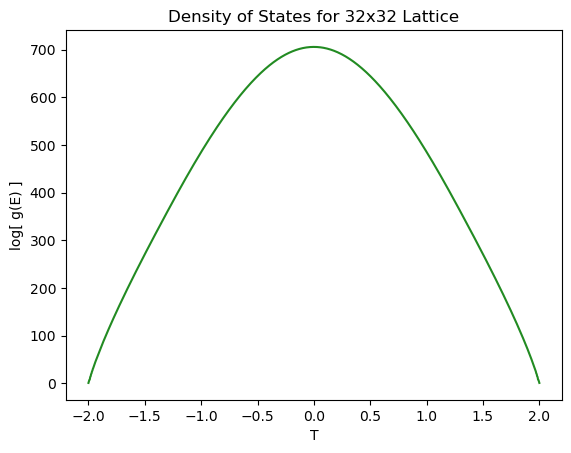

In [54]:
E_32 = np.array(calc_E_spectrum(32))
plt.plot(E_32/32**2,norm_log_32,color='forestgreen',label=f'Lattice Size: {32**2}')
plt.xlabel('T')
plt.ylabel('log[ g(E) ]')
plt.title('Density of States for 32x32 Lattice')

Emax = 2048.0, Emin = -2048.0, dE = 4.0


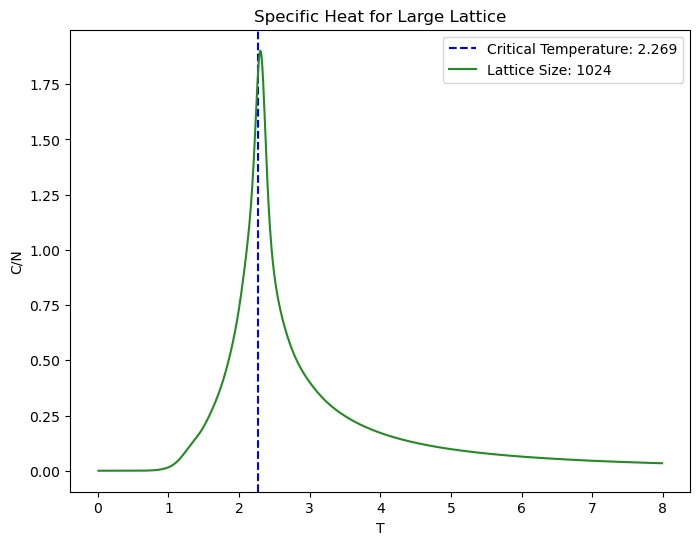

In [52]:
E_32 = np.array(calc_E_spectrum(32))

T_s = np.arange(0.01,8,0.01)



# F_s = []
# for T in T_s:
#     Z_sum = 0
#     for i,E in enumerate(E_32):
#         exponent = norm_log_32[i]-E/T
#         Z_sum += np.exp(np.log(exponent))
        
        
#     F_s.append(-T*np.log(Z_sum))  
    
    
C_s = []

for T in T_s:
    Z = np.sum(np.exp(norm_log_32 - (E_32+np.max(E_32))/T))
    #print(Z)
    
    E = np.sum(E_32*np.exp(norm_log_32 - (E_32+np.max(E_32))/T))/Z
    
    E2 = np.sum(E_32**2*np.exp(norm_log_32 - (E_32+np.max(E_32))/T))/Z
    
    C_s.append((E2-E**2)/T**2/32**2)
    
plt.figure(figsize=(8,6))
plt.axvline(x=2.269,linestyle='--',color='b',label=f'Critical Temperature: {2.269}')

plt.plot(T_s,C_s,color='forestgreen',label=f'Lattice Size: {32**2}')
plt.xlabel('T')
plt.ylabel('C/N')
plt.title('Specific Heat for Large Lattice')
plt.legend()
plt.show()

Emax = 32.0, Emin = -32.0, dE = 4.0
Emax = 128.0, Emin = -128.0, dE = 4.0
Emax = 512.0, Emin = -512.0, dE = 4.0
Emax = 2048.0, Emin = -2048.0, dE = 4.0


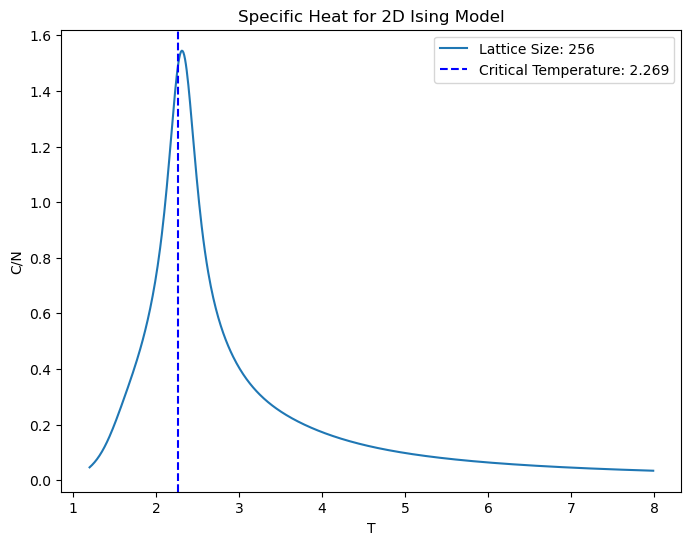

In [31]:
def no_inf(arr):
    arr_s_min = arr[arr < 10**200]
    arr[arr > 10**200] = np.min(arr_s_min)    
    return arr
 
    
#     arr_min = arr[arr != -np.inf]
#     arr[np.isinf(arr)] = np.max(arr_min)
    return arr
    
lat_sizes = [4,8,16,32]
E_spec_s = [np.array(calc_E_spectrum(i)) for i in lat_sizes]


T_s = np.arange(1.2,8,0.01)


plt.figure(figsize=(8,6))
with np.errstate(all='ignore'):

    for i in range(len(lat_sizes)):
        if lat_sizes[i] != 16:
            continue
        F_s = []
        
        F_exact = []
        F_errs = []
        
        C_s = []
        U_s = []
        S_s = []
        Z_s = []
        for T in T_s:
            Z_non_sum = np.exp(norm_log_g_s[i])*np.exp(-E_spec_s[i]/T)
#             Z_no_inf = no_inf(Z_non_sum)
#             Z = np.sum(Z_no_inf)            
            Z = np.sum(Z_non_sum)
    
            F = -T*np.log(Z)/lat_sizes[i]**2
#             F_an = analytical_F(T,10**7)
#             F_exact.append(F_an.n)
#             F_errs.append(F_an.s)
            
            S = (np.log(Z)+E/T)/lat_sizes[i]**2

            E = np.sum(E_spec_s[i]*no_inf(np.exp(norm_log_g_s[i])*np.exp(-E_spec_s[i]/T)))/Z
                        
            E_2 = np.sum(E_spec_s[i]**2*no_inf(np.exp(norm_log_g_s[i])*no_neg_inf(np.exp(-E_spec_s[i]/T))))/Z
            C = ((E_2-E**2)/T**2) / lat_sizes[i]**2
            
            Z_s.append(np.log(Z/lat_sizes[i]**2))
            U_s.append(E/lat_sizes[i]**2)
            S_s.append(S)
            F_s.append(F)
            C_s.append(C)
        
        #print(C_s)
        C_s = np.array(C_s)
        C_s[np.isnan(C_s)] = 0
        
        U_s = np.array(U_s)
        U_filt = U_s[~np.isnan(U_s)]
        U_s[np.isnan(U_s)] = np.min(U_filt)  
                
        F_s = np.array(F_s)
        F_s_min = F_s[F_s != -np.inf]
        F_s[np.isinf(F_s)] = np.max(F_s_min)
        
        Z_s = np.array(Z_s)
        Z_s_min = Z_s[Z_s != np.inf]
        Z_s[np.isinf(Z_s)] = np.max(Z_s_min)
        
        S_s = np.array(S_s)
        S_filt = S_s[~np.isnan(S_s)]
        S_s[np.isnan(S_s)] = np.min(S_filt)  

            #------PARTITION FUNCTION--------#        
#         plt.plot(T_s,Z_s,label=f'Lattice Size: {lat_sizes[i]**2}')
#         plt.ylabel('Z/N')
#         plt.title('Partition Function for 2D Ising Model')
    
            #------GIBBS FREE ENERGY--------#        
#         plt.plot(T_s,F_s,label=f'Lattice Size: {lat_sizes[i]**2}')
#         plt.plot(T_s,F_exact,label='Exact Solution')
        
#         F_u = np.array([ufloat(F_exact[i],F_errs[i]) for i in range(len(F_exact))])
#         rel_err = np.absolute((np.array(F_s) - F_u)/F_u)
        
#         nom_rel_err = [i.n for i in rel_err]
#         plt.plot(T_s,nom_rel_err,label='Relative Error',color='forestgreen')
        
#         std_rel_err = [i.s for i in rel_err]
#         print(np.mean(std_rel_err),np.max(std_rel_err))
#         plt.ylabel('Relative Error')
#         plt.title('Relative Error')

            #------SPECIFIC HEAT--------#   
        plt.plot(T_s,C_s,label=f'Lattice Size: {lat_sizes[i]**2}')
        plt.ylabel('C/N')
        plt.title('Specific Heat for 2D Ising Model')

            #------AVERAGE ENERGY PER SITE------#
#         plt.plot(T_s,U_s,label=f'Lattice Size: {lat_sizes[i]**2}')
#         plt.ylabel('E/N')
#         plt.title('Energy per Site for 2D Ising Model')

            #------ENTROPY PER SITE ENERGY--------#        
#         plt.plot(T_s,S_s,label=f'Lattice Size: {lat_sizes[i]**2}',color='purple')
#         plt.ylabel('S/N')
#         plt.title('Entropy per Site for 2D Ising Model')
        
        plt.xlabel('T')

plt.axvline(x=2.269,linestyle='--',color='b',label=f'Critical Temperature: {2.269}')

        
plt.legend()

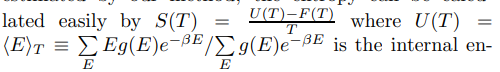
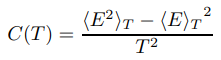
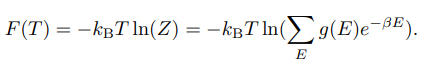

In [2]:
#THE CELLS BELOW ARE INDEPENDANT NOTES FOR HOW THE ISING MODEL WORKS

#EXPLANATION OF HOW ENERGY IS CALCULATED:

#It actually calculates all unique nearest neighbors WITH a periodic boundary condition
#thus each site actually has 4 neighbors even if it is on the edge


def Energy_Intuitive(latt): #same as CEnergy
    #Energy of a 2D Ising lattice with J=1
    Ene = 0
    for i in range(N):
        for j in range(N):
            site = latt[i,j]
            #assumes periodic boundary condition and double counts all lattice sites
            #The %N just ensures periodic boundary coniditon
            nearest_neighbors = latt[(i+1)%N, j] + latt[i,(j+1)%N] + latt[(i-1)%N,j] + latt[i,(j-1)%N]
            #performs sum of neigherest neighbors with current energy site
            Ene += -site*nearest_neighbors # perform calc: -site * (nearest_1 + nearest_2 + nearest_3 + nearest_4)
    return int(Ene/2.)   # Each par counted twice

def CEnergy(latt):
    "Energy of a 2D Ising lattice"
    Ene = 0
    for i in range(N):
        for j in range(N):
            S = latt[i,j]
            print('')
            print(f'Current Lattice site: {S}')
            WF = latt[(i+1)%N, j] + latt[i,(j+1)%N] + latt[(i-1)%N,j] + latt[i,(j-1)%N]
            print(f'Neighbor {((i-1)%N,j)}: {latt[(i-1)%N,j]}   and    Neighbor {((i+1)%N,j)}: {latt[(i+1)%N,j]}')
            print(f'Neighbor {(i,(j-1)%N)}: {latt[i,(j-1)%N]}   and    Neighbor {(i,(j+1)%N)}: {latt[i,(j+1)%N]}')
            print(f'Energy += WF*S = {WF}*{S} = {WF*S}')
            Ene += -WF*S # Each neighbor gives energy 1.0
            print(f'Energy_current: {Ene}')
    return int(Ene/2.)   # Each par counted twice

def bad_Energy(lat,J=1):
    def E_along(row,J=1):
        return sum([-J*row[(i+1)]*row[i] for i in range(0,len(row)-1)])
    
    E_lat = sum([E_along(row) for row in lat])
    E_lat_T = sum([E_along(row) for row in lat.T])
    return E_lat + E_lat_T


def Energy2(latt):
    Ene = -np.sum(latt*(np.roll(latt,1,axis=0) + np.roll(latt,-1,axis=0) + np.roll(latt,1,axis=1) + np.roll(latt,-1,axis=1)))
    return int(Ene/2.)

N = 3
N_squared = N**2
lattice = (2*np.random.randint(2,size=(1,N_squared))[0]-1).reshape((N,N))

# test_lat = np.array([1]*N**2).reshape((N,N))
# print(test_lat)
# print(CEnergy(test_lat))
# print(Energy2(test_lat))



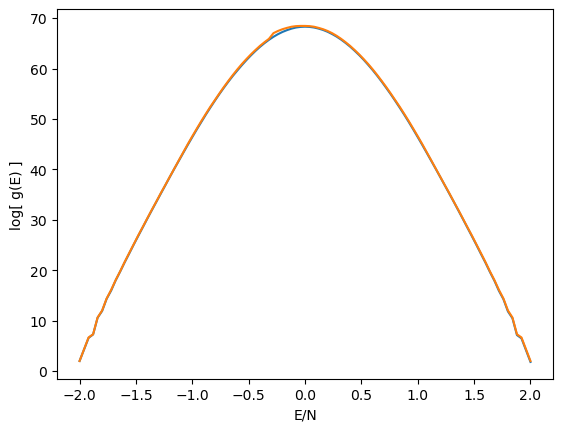
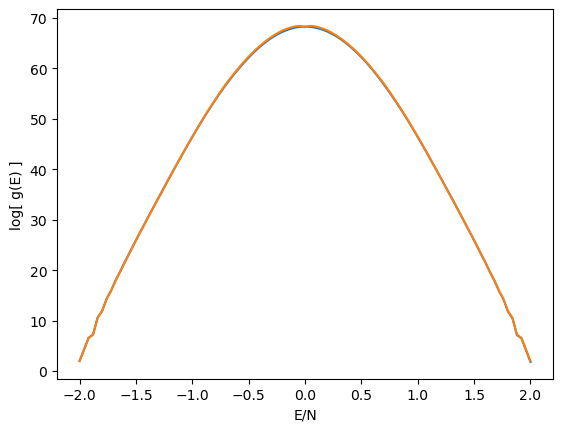



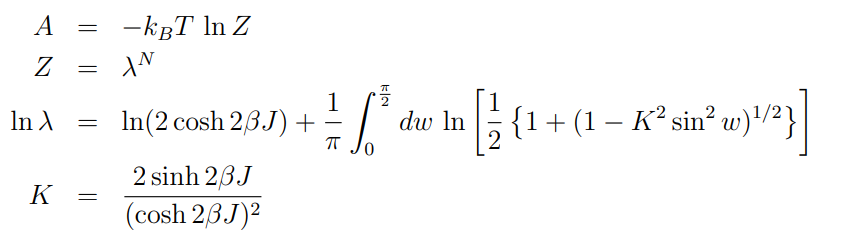

In [5]:
log_g_64 = Fast_WL(32)

Emax = 2048.0, Emin = -2048.0, dE = 4.0
[-204. -200. -196. -192. -188. -184. -180. -176. -172. -168. -164. -160.
 -156. -152. -148. -144. -140. -136. -132. -128. -124. -120. -116. -112.
 -108. -104. -100.  -96.  -92.  -88.  -84.  -80.  -76.  -72.  -68.  -64.
  -60.  -56.  -52.  -48.  -44.  -40.  -36.  -32.  -28.  -24.  -20.  -16.
  -12.   -8.   -4.    0.    4.    8.   12.   16.   20.   24.   28.   32.
   36.   40.   44.   48.   52.   56.   60.   64.   68.   72.   76.   80.
   84.   88.   92.   96.  100.  104.  108.  112.  116.  120.  124.  128.
  132.  136.  140.  144.  148.  152.  156.  160.  164.  168.  172.  176.
  180.  184.  188.  192.  196.  200.  204.  208.  212.  216.  220.  224.
  228.  232.  236.  240.  244.  248.  252.  256.  260.  264.  268.  272.
  276.  280.  284.  288.  292.  296.  300.  304.  308.  312.  316.  320.
  324.  328.  332.  336.  340.  344.  348.  352.  356.  360.  364.  368.
  372.  376.  380.  384.  388.  392.  396.  400.  404.  408.  412.  416.
  420.  424

/tmp/ipykernel_4987/2055001089.py:136: RuntimeWarning: overflow encountered in exp
  prob_acceptance = np.exp(g_curr - g_proposed) #g_curr/g_proposed


1 success 18920764
2 success 23558987
3 success 27482578
4 success 30785002
5 success 35143239
6 success 38985772
7 success 43184540
8 success 46694980
9 success 50511481
10 success 57331433
11 success 64762448
12 success 73416343
13 success 82734108
14 success 95360191
15 success 127372618
16 success 184201625
17 success 236913535
18 success 278945101
19 success 361696829
20 success 560608438
21 success 703150277
22 success 781322547
23 success 913181037
24 success 938391537
25 success 958420885
26 success 1007029244
27 success 1099411481
Done with 32


In [7]:
print(log_g_64.tolist())

[40681.96132624149, 40688.837775975466, 40689.55966296792, 40695.124081522226, 40696.513676419854, 40700.959612607956, 40702.75746071339, 40706.57554522157, 40708.59358024597, 40711.99353572726, 40714.182159096, 40717.25452621281, 40719.56205767393, 40722.408229231834, 40724.779523298144, 40727.466881752014, 40729.85359430313, 40732.443684101105, 40734.83413092792, 40737.346484050155, 40739.74046750367, 40742.165239050984, 40744.546982467175, 40746.93628746271, 40749.27131190896, 40751.61774626374, 40753.937870025635, 40756.240134984255, 40758.55230142176, 40760.84054411948, 40763.09549476206, 40765.358478948474, 40767.59612338245, 40769.83564354479, 40772.04967702925, 40774.26541592181, 40776.46896997094, 40778.647890642285, 40780.83939088881, 40783.00156740844, 40785.15068973601, 40787.30660825968, 40789.45770600438, 40791.58996531367, 40793.70912396908, 40795.821025669575, 40797.9402256161, 40800.04186435044, 40802.13115528226, 40804.20571707189, 40806.300462022424, 40808.3658545017

In [31]:
log_test = Fast_WL(2)

norm_log = np.log(np.exp(log_test-log_test[0])+1)
print(np.exp(norm_log))


Emax = 8.0, Emin = -8.0, dE = 4.0
[0. 8.]
1 success 2
2 success 1539
3 success 1566
4 success 1568
5 success 1603
6 success 1618
7 success 1623
8 success 1627
9 success 1629
10 success 1633
11 success 1648
12 success 1655
13 success 1657
14 success 1717
15 success 1719
16 success 1724
17 success 1743
18 success 1747
19 success 1754
20 success 1758
Done with 2
[2.         5.56718158 2.        ]


In [26]:
print(calc_E_spectrum(2))

Emax = 8.0, Emin = -8.0, dE = 4.0
[-8.  0.  8.]


In [48]:
log_8 = Fast_WL(10)
norm_log_8 = np.log(np.exp(log_8-log_8[0])+1)
print(np.sum(norm_log_8))

Emax = 200.0, Emin = -200.0, dE = 4.0
-20.0
1 success 83905
2 success 103917
3 success 137200
4 success 157275
5 success 214640
6 success 250379
7 success 290612
8 success 377836
9 success 474757
10 success 569291
11 success 755392
12 success 1044443
13 success 1485517
14 success 1624383
15 success 2210983
16 success 2666683
17 success 2951693
18 success 3126571
19 success 3396526
20 success 3591974
21 success 3993631
22 success 4175330
23 success 4341904
24 success 4873032
25 success 5175485
26 success 6129702
27 success 6236217
Done with 10
4114.44358611702


In [49]:
print(np.log(np.sum(np.exp(norm_log_8))))
print(100*np.log(2))


68.71127662090127
69.31471805599453


In [51]:
print(np.log(np.sum(np.exp(norm_log_32))))
print(32**2 * np.log(2))

708.9338328937513
709.782712893384


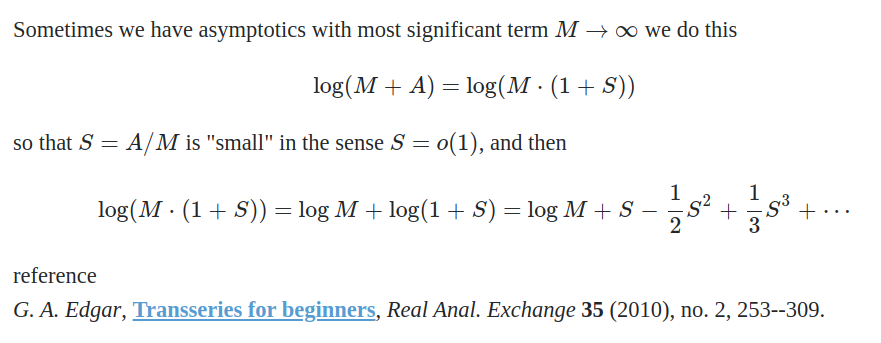